In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
from mock_test import *
#from run_error_analysis import *
#from plot_chain import plot_single, plot_triple, plot_distributions, plot_summary_bar
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Initialize Class, Calculate datavector and cov matrices

No Shotnoise, No Finger of God term

In [2]:
"""
 b = galaxy bias
 f = structure growth rate
 s = velocity dispersion in FoG term 
 nn = shot noise 
"""
cosmo = class_covariance(KMIN=0.001, KMAX = 100, n=300, RMIN = 0.001, RMAX = 200, n2 = 101, \
                         b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin', smooth_filter=True)

#cosmo.compile_fortran_modules()

# copy class to keep initial setting
cosmo2 = cosmo
cosmo2.MatterPower()

# calling matter power spectrum from camb
cosmo.MatterPower()
p_model = cosmo.multipole_P(0)
xi_model = cosmo.multipole_Xi(0)

# calculate covariance matrix
covp_model = cosmo.covariance_PP(0,0)     # cov P monopole
covxi_model = cosmo.covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
covpxi_model = cosmo.covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model
covtot_model = np.vstack(( np.hstack((covp_model, covpxi_model )), \
                          np.hstack((covpxi_model.T, covxi_model )) ))   # cov_combined
dpdb,_,_ = cosmo.derivative_P_bfs(0)      # dp/db
dxdb,_,_ = cosmo.derivative_bfs(0)        # dxi/db

TypeError: __init__() got an unexpected keyword argument 'smooth_filter'

## Generate Mocks

In [4]:
header = "class_covariance(KMIN=0.001, KMAX = 10, n=3000, RMIN = 0.001, RMAX = 200, n2 = 41, \
                         b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin')"
dirs = '../data_txt/mocks22/'
p_mock, xi_mock = generate_mocks( cosmo, p_model, covp_model, N_mock = 100 )
save_mocks( cosmo, p_mock, xi_mock, header = header, dir = dirs  )
kcenter, p_mock, rcenter, xi_mock = load_mocks(dir = dirs)
mocks = np.hstack(( p_mock, xi_mock ))

generate mocks... size= 100


Mock Covariance matrices

In [5]:
mock_covpxi = mock_covariance(p_model, xi_model, p_mock, xi_mock)
mock_covp = mock_covariance(p_model, p_model, p_mock, p_mock)
mock_covxi = mock_covariance(xi_model, xi_model, xi_mock, xi_mock)
mock_covtot = np.vstack(( np.hstack((mock_covp, mock_covpxi )), np.hstack((mock_covpxi.T, mock_covxi )) ))

### Theory Datavector with varying bias

#### 2D Interpolation 

In [6]:
datavp_interp, datavxi_interp = datavector_bias_2d_interp(cosmo)
cosmo.b = 2.0 

Calculate datavector p(b) and xi(b) for b = [0.5,3.5]
generate 2D interpolation table 


In [7]:
# interpolate
bbin = np.linspace(0.5, 3.5, 20000)
datav_p = datavp_interp(cosmo.kbin, bbin)
datav_xi = datavxi_interp(cosmo.rcenter, bbin)
datav_com = np.hstack((datav_p, datav_xi))

#### Mock, Theory data vectors

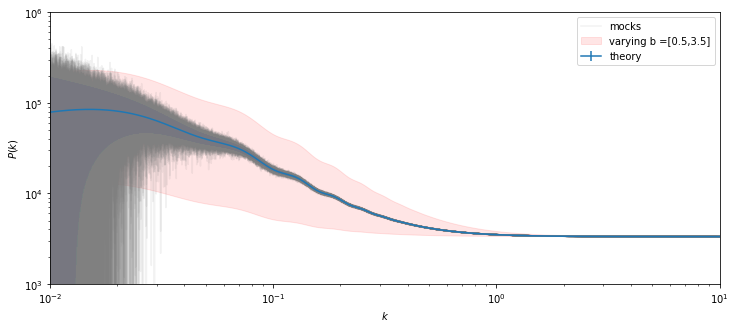

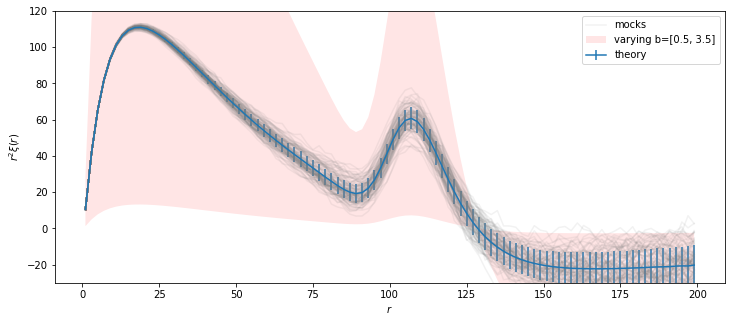

In [8]:
kcenter = cosmo.kbin
fig, ax = plt.subplots(figsize = (12,5))
#for i in range(100): 

for i in range(len(p_mock)) : ax.plot(kcenter, p_mock[i],  color='grey', alpha = 0.1)
ax.plot(kcenter, p_mock[-1], color='grey', alpha = 0.1, label = 'mocks')

ax.errorbar(kcenter, p_model, \
            yerr = np.sqrt(covp_model.diagonal()), fmt='', label = 'theory')

ax.fill_between(cosmo.kbin, datav_p[0], datav_p[-1], color = 'red', alpha = 0.1, label = 'varying b =[0.5,3.5]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-02, 10)
ax.set_ylim(1e03, 1e06)
ax.legend(loc='best')
ax.set_ylabel(r'$P(k)$')
ax.set_xlabel(r'$k$')

fig, ax = plt.subplots(figsize = (12,5))
#for i in range(10): 
for i in range(len(xi_mock)) : ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi_mock[i], color='grey', alpha = 0.1)
ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi_mock[-1], color='grey', alpha = 0.1, label = 'mocks')
ax.errorbar(cosmo.rcenter, cosmo.rcenter**2*xi_model, \
            yerr = cosmo.rcenter**2*np.sqrt(covxi_model.diagonal()), fmt='',label = 'theory')
ax.fill_between(cosmo.rcenter, cosmo.rcenter**2* datav_xi[0], 
                cosmo.rcenter**2* datav_xi[-1], facecolor = 'red', alpha = 0.1, label = 'varying b=[0.5, 3.5]')
ax.set_ylim(-30, 120)
ax.set_ylabel(r'$r^2 \xi(r)$')
ax.set_xlabel(r'$r$')
ax.legend(loc='best')

#### Mock cov, Theoretical Cov

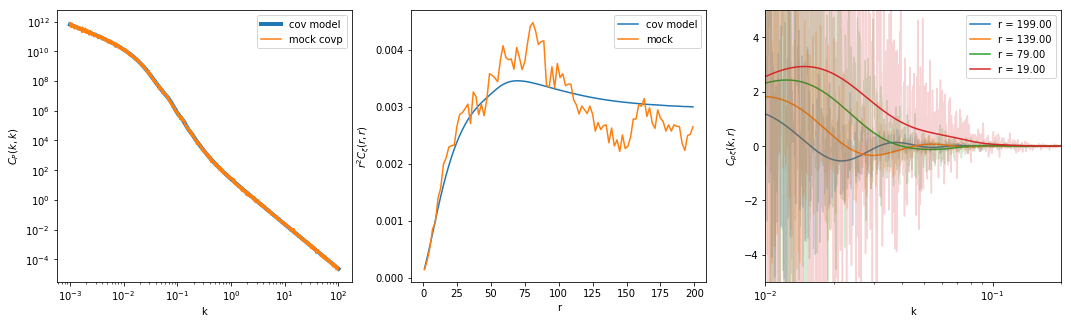

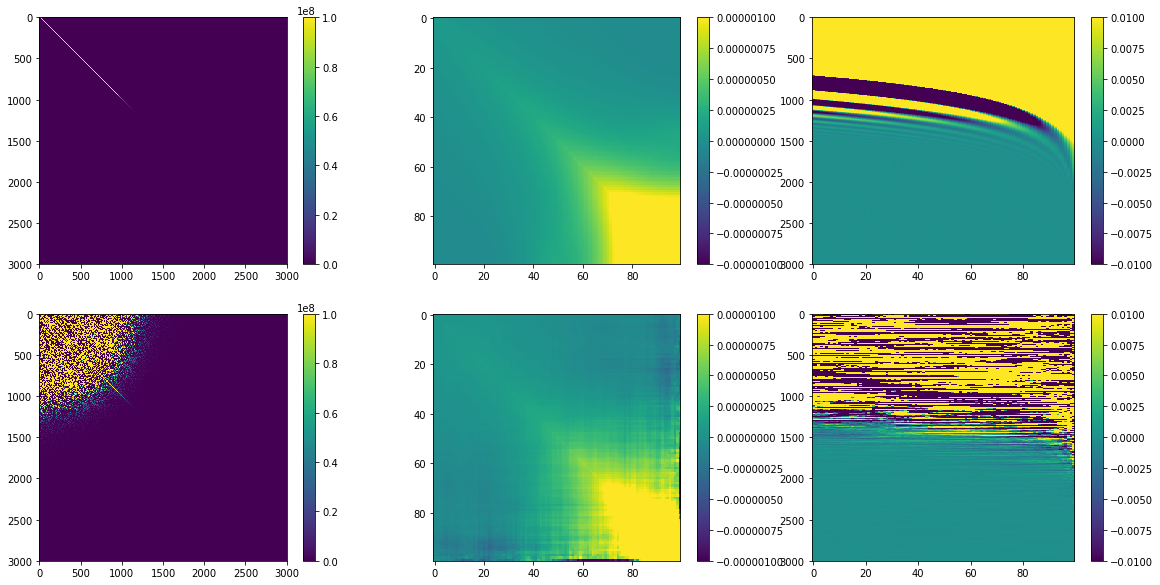

In [9]:
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (18,5))

kcenter = cosmo.kbin
ax.loglog(kcenter, covp_model.diagonal(), '-', linewidth = 4.0, label = 'cov model')
ax.loglog(kcenter, mock_covp.diagonal(), '-', label ='mock covp')
ax.set_xlabel('k')
ax.set_ylabel(r'$C_P (k,k)$')
ax.legend()

#fig, ax = plt.subplots()
ax2.plot(cosmo.rcenter, cosmo.rcenter**2*covxi_model.diagonal(), label='cov model')
ax2.plot(cosmo.rcenter, cosmo.rcenter**2*mock_covxi.diagonal(), '-', label = 'mock')
#ax.plot(cosmo.rcenter, cosmo.rcenter**2*cov_xi_3.diagonal(), '-', label = 'model2')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$r^2 C_{\xi}(r,r)$')
ax2.legend()


#fig, ax = plt.subplots()
for i in np.arange(0, cosmo.rcenter.size, 30):
    ax3.plot(cosmo.kbin, mock_covpxi[:,i], alpha = 0.2)
    ax3.plot(cosmo.kbin, covpxi_model[:,i], label='r = {:0.2f}'.format(cosmo.rcenter[i]), color = ax3.lines[-1].get_color())
    
ax3.set_ylim(-5, 5)
ax3.set_xlim(1e-02,0.2)
ax3.set_xlabel('k')
ax3.set_ylabel(r'$C_{p\xi}(k,r)$')
ax3.set_xscale('log')
ax3.legend(loc='best')


fig, ((ax, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (20,10))
im = ax.imshow(covp_model, vmax = 1e8, vmin = 0)
im2 = ax2.imshow(covxi_model, vmax=0.000001, vmin=-0.000001)
im3 = ax3.imshow(covpxi_model, aspect='auto', vmax=0.01, vmin=-0.01)

im4 = ax4.imshow(mock_covp, vmax = 1e8, vmin = 0)
im5 = ax5.imshow(mock_covxi, vmax=0.000001, vmin=-0.000001)
im6 = ax6.imshow(mock_covpxi, aspect='auto', vmax=0.01, vmin=-0.01)

fig.colorbar(im,ax=ax)
fig.colorbar(im2,ax=ax2)
fig.colorbar(im3,ax=ax3)
fig.colorbar(im4,ax=ax4)
fig.colorbar(im5,ax=ax5)
fig.colorbar(im6,ax=ax6)

## Calcuate Bestfit Bias 

Setting k range and r range

In [10]:
kmin = 0.01
kmax = 0.1
rmin = 20
rmax = 180

#### Theoretical calculation 

In [11]:
sigma_p = getting_sigma_bs_theory( cosmo2, b = bbin, cov = covp_model, datavs = datav_p, 
                                     mockdatavs = None, p=True, kmin=kmin, kmax=kmax )
sigma_x = getting_sigma_bs_theory( cosmo2, b = bbin, cov = covxi_model, datavs = datav_xi, 
                                     mockdatavs = None, rmin = rmin, rmax=rmax )
sigma_d = getting_sigma_bs_diff_theory( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = None, mockdatavsxi = None, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
sigma_c = getting_sigma_bs_com_theory( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = None,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

# print out results-------------------------------
print '---------------------------------\
\n Error on bias (Theory) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_p, sigma_x, sigma_c, sigma_d)

Nk  601  kmin 600  kmax 1200
 theory : 0.006379726612099409
Nr  80  rmin 89  rmax 10
 theory : 0.008963724793832778
Nk  601  kmin 600  kmax 1200
Nr  80  rmin 89  rmax 10
 theory : 0.005197679404796241
N  681  kmin 600  kmax 1200  rmin 89  rmax 10
 theory : 0.002572902195259961
---------------------------------
 Error on bias (Theory) 
 sigma_p      : 0.0063797266121 
 sigma_xi     : 0.00896372479383 
 sigma_combin : 0.00257290219526 
 sigma_diff   : 0.0051976794048 
---------------------------------


#### Mock : Perform chisquare calculation to obtain bestfit biases with Cp, Cxi, Ctot, Cdiff

Nk  601  kmin 600  kmax 1200


TypeError: 'NoneType' object has no attribute '__getitem__'

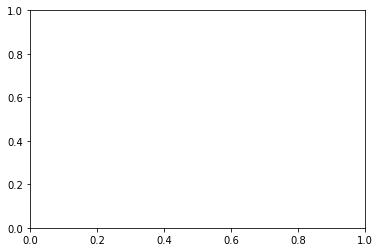

In [12]:

bestfit_b_p, chi2p = getting_sigma_bs( cosmo2, b = bbin, cov = covp_model, datavs = None, 
                                     mockdatavs = p_mock, p=True, kmin=kmin, kmax=kmax )
bestfit_b_xi, chi2x = getting_sigma_bs( cosmo2, b = bbin, cov = covxi_model, datavs = None, 
                                     mockdatavs = xi_mock, rmin = rmin, rmax=rmax )
bestfit_b_diff ,chi2_diff = getting_sigma_bs_diff( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = None, datavsxi = None, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
bestfit_b_com, chi2_com = getting_sigma_bs_com( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = None, mockdatavs = mocks,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

In [ ]:
# print out results-------------------------------
sigma_pm, sigma_xm, sigma_cm, sigma_dm \
= np.std(bestfit_b_p), np.std(bestfit_b_xi), np.std(bestfit_b_com), np.std(bestfit_b_diff)
print '---------------------------------\
\n Error on bias (Mock) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_pm, sigma_xm, sigma_cm, sigma_dm)

#### Uncorrelated P and Xi mocks

In [ ]:
xi_mock2 = np.vstack((xi_mock[1:,], xi_mock[0,:]))

In [ ]:
mocks2 = np.hstack((p_mock, xi_mock2))
bestfit_b_diff2 = getting_sigma_bs_diff( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock2, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
bestfit_b_com2 = getting_sigma_bs_com( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = mocks2,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

In [ ]:
# print out results-------------------------------
sigma_cm2, sigma_dm2 = np.std(bestfit_b_com2[0]), np.std(bestfit_b_diff2[0])
print '---------------------------------\
\n Error on bias (Uncorrelated Mock) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_cm2, sigma_dm2)

#### Obtain cross bias from bestfit b_p and b_xi

In [ ]:
combine_sigmab(bestfit_b_p, bestfit_b_xi)

#### Check outliers 

In [ ]:
bhist_bin = np.linspace(0.5, 3.5, 1000)
fig, ax = plt.subplots()
_, _, _ = ax.hist( bestfit_b_p, bins = bhist_bin, label = 'sigma_p' )
_, _, _ = ax.hist( bestfit_b_xi, bins = bhist_bin, label = 'sigma_xi', alpha=0.5 )
Nb, _, _ = ax.hist( bestfit_b_com, bins = bhist_bin, label = 'sigma_combine' ,alpha=0.5)
Nb2, _, _ = ax.hist( bestfit_b_diff, bins = bhist_bin, label = 'sigma_diff', alpha = 0.5 )
ax.set_xlabel('bestfit b')
ax.set_ylabel('N');
ax.set_xlim(1.9, 2.1)
ax.legend()

nonzero = bhist_bin[:-1][ Nb > 0.0]
nonzero2= bhist_bin[:-1][ Nb2 > 0.0]
print '\nbestfit b exists between b=[{}, {}]'.format(nonzero.min(), nonzero.max() )
print 'bestfit b exists between b=[{}, {}]\n'.format(nonzero2.min(), nonzero2.max() )

#### Chi2 distribution test

In [ ]:
chibin = np.linspace(0.5, 1.5, 50)
fig, ax = plt.subplots()
#ax.plot( np.arange(len(chi2p) ), chi2p)
ax.hist(chi2p, bins = chibin, label='p', histtype='step');
ax.hist(chi2x, bins = chibin, label ='xi', histtype='step');
ax.hist(chi2_diff, bins = chibin, label='diff', histtype='step');
ax.hist(chi2_com, bins = chibin, label='combin', histtype='step');
ax.set_xlabel('chi2')
ax.legend()

In [48]:
print '* with SHOT Noise'

# print out results-------------------------------
print '---------------------------------\
\n#1 Error on bias (Theory) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_p, sigma_x, sigma_c, sigma_d)

# print out results-------------------------------
sigma_pm, sigma_xm, sigma_cm, sigma_dm \
= np.std(bestfit_b_p), np.std(bestfit_b_xi), np.std(bestfit_b_com), np.std(bestfit_b_diff)
print '---------------------------------\
\n#2 Error on bias (Mock) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n'.format(sigma_pm, sigma_xm, sigma_cm, sigma_dm)

# print out results-------------------------------
sigma_cm2, sigma_dm2 = np.std(bestfit_b_com2[0]), np.std(bestfit_b_diff2[0])
print ' (Uncorrelated Mock) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_cm2, sigma_dm2)

print '---------------------------------\n\
#3 Error on bias \n \
(Mock, cross bias is obtained \n from bestfit bias of P and Xi)\n'
combine_sigmab(bestfit_b_p, bestfit_b_xi)

* with SHOT Noise
---------------------------------
#1 Error on bias (Theory) 
 sigma_p      : 0.0063797266121 
 sigma_xi     : 0.00899008324001 
 sigma_combin : 0.00262687042688 
 sigma_diff   : 0.0052028034416 
---------------------------------
---------------------------------
#2 Error on bias (Mock) 
 sigma_p      : 0.00642056635073 
 sigma_xi     : 0.00917669041399 
 sigma_combin : 0.00262308349839 
 sigma_diff   : 0.00687456732089 

 (Uncorrelated Mock) 
 sigma_combin : 0.461586799763 
 sigma_diff   : 0.00464687209723 
---------------------------------
---------------------------------
#3 Error on bias 
 (Mock, cross bias is obtained 
 from bestfit bias of P and Xi)

cov matrix = 
 |0.0000412237   0.0000436698| 
 |0.0000436698   0.0000842116|

sigma_p       : 0.006420566350733192
sigma_xi      : 0.009176690413987283
sigma_combin  : 0.006408322976568798
sigma_diff    : 0.005260772232375363


-------------------

==========

In [23]:
def mock_covariance_xib(xi_model, xi_mock, bestfit_b, b_model):
    #m1, m2 = np.mgrid[0:1, 0:xi_model.size]
    mock_covbxi = np.zeros(( 1, xi_model.size ))
    for i in range(len(xi_mock)) :
        #p = p_mock[i]
        b = bestfit_b[i]
        x = xi_mock[i]
        mock_covbxi += ( b - b_model) * (x - xi_model)
        print '{}/{}                \r'.format(i+1, len(bestfit_b)),
    mock_covbxi = 1./( len(bestfit_b) - 1 ) * mock_covbxi
    
    #if p_model.size == xi_model.size : mock_covpxi = (mock_covpxi + mock_covpxi.T)/2.
    return mock_covbxi


def mock_covariance_pb(p_model, p_mock, bestfit_b, b_model):
    #m1, m2 = np.mgrid[0:1, 0:xi_model.size]
    mock_covbxi = np.zeros(( 1, p_model.size ))
    for i in range(len(p_mock)) :
        #p = p_mock[i]
        b = bestfit_b[i]
        p = p_mock[i]
        mock_covbxi += ( b - b_model) * (p - p_model)
        print '{}/{}                \r'.format(i+1, len(bestfit_b)),
    mock_covbxi = 1./( len(bestfit_b) - 1 ) * mock_covbxi
    
    #if p_model.size == xi_model.size : mock_covpxi = (mock_covpxi + mock_covpxi.T)/2.
    return mock_covbxi

In [24]:
#kmin = 0.001
#kmax = 0.06
#rmin = 20
#rmax = 200

idx_kmin = get_closest_index_in_data( kmin, cosmo.kbin )   
idx_kmax = get_closest_index_in_data( kmax, cosmo.kbin )

idx_rmin = get_closest_index_in_data( rmin, cosmo.rmin )   
idx_rmax = get_closest_index_in_data( rmax, cosmo.rmax )

rbin = cosmo.rcenter[idx_rmax:idx_rmin]
kbin = cosmo.kcenter[idx_kmin:idx_kmax]

sigma_d = getting_sigma_bs_diff_theory( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
sigma_c = getting_sigma_bs_com_theory( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = mocks,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

# print out results-------------------------------
print '---------------------------------\
\n Error on bias (Theory) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_c, sigma_d)

Nk  1068  kmin 0  kmax 1067
Nr  90  rmin 89  rmax 0
 theory : 0.007393552229134158
N  1158  kmin 0  kmax 1067  rmin 89  rmax 0
 theory : 0.0032654014604566114
---------------------------------
 Error on bias (Theory) 
 sigma_combin : 0.00326540146046 
 sigma_diff   : 0.00739355222913 
---------------------------------


In [25]:
Fpp = np.linalg.inv(covp_model[idx_kmin:idx_kmax, idx_kmin:idx_kmax])
Fpb = np.dot(Fpp, dpdb[idx_kmin:idx_kmax])
Cxib = np.dot( covpxi_model[idx_kmin:idx_kmax,idx_rmax:idx_rmin].T, Fpb )  
final = np.dot( np.linalg.inv(covxi_model[idx_rmax:idx_rmin, idx_rmax:idx_rmin]), Cxib)
#mock_covbxi = mock_covariance_xib(xi_model, xi_mock, bestfit_b_p, 2.0)
#final_mock = np.dot(mock_covbxi[:,idx_rmax:idx_rmin], np.linalg.inv(mock_covxi[idx_rmax:idx_rmin, idx_rmax:idx_rmin]) )


In [26]:
#bestfit_b_p, chi2p = getting_sigma_bs( cosmo2, b = bbin, cov = covp_model, datavs = datav_p, 
#                                     mockdatavs = p_mock, p=True, kmin=kmin, kmax=kmax )
#bestfit_b_xi, chi2x = getting_sigma_bs( cosmo2, b = bbin, cov = covxi_model, datavs = datav_xi, 
#                                     mockdatavs = xi_mock, rmin = rmin, rmax=rmax )
#sigma_pm = np.std(bestfit_b_p)
#sigma_xm = np.std(bestfit_b_xi)

In [27]:
covdiag = covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal()
DAT = np.column_stack((rbin, Cxib, covdiag, final))
header = 'rbin, cxib, cxi_diag, final, final_mock \n# kmin {} kmax {} rmin {} rmax{}'.format(kmin, kmax, rmin, rmax)
filename = '../data_txt/chris/cov_test_k{:0.2f}_{:0.2f}.txt'.format(kmin, kmax)
np.savetxt(filename, DAT, header=header)

In [28]:
#Fxi = np.linalg.inv(covxi_model[idx_rmax:idx_rmin, idx_rmax:idx_rmin])
#Fxib = np.dot(Fxi, dxdb[idx_rmax:idx_rmin])
#Cpb = np.dot( covpxi_model[idx_kmin:idx_kmax,idx_rmax:idx_rmin], Fxib )  
#final_p = np.dot( np.linalg.inv(covp_model[idx_kmin:idx_kmax, idx_kmin:idx_kmax]), Cpb)
#mock_covbp = mock_covariance_pb(p_model, p_mock, bestfit_b_xi, 2.0)
#final_mock_p = np.dot(mock_covbp[:,idx_kmin:idx_kmax], np.linalg.inv(mock_covp[idx_kmin:idx_kmax, idx_kmin:idx_kmax]) )

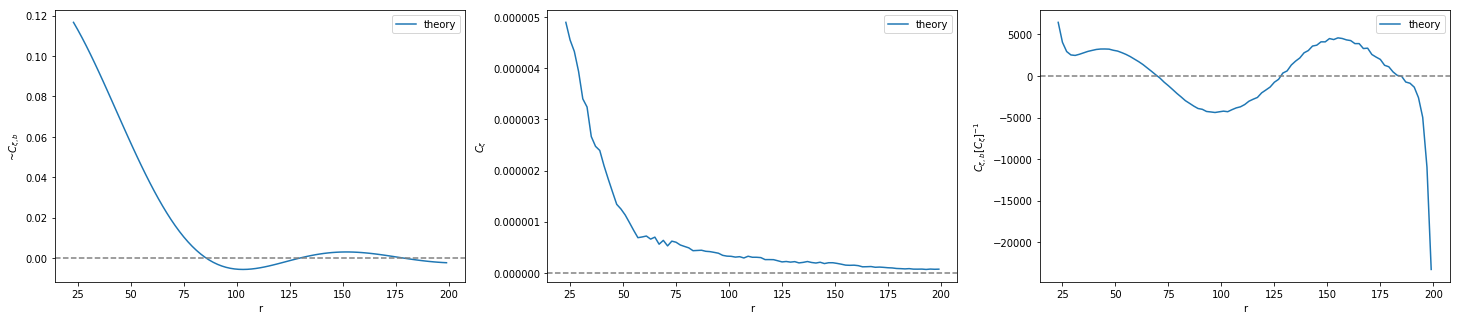

In [26]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin,Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~$C_{\xi,b}$')
ax.legend()
#ax.set_ylim(-50000,50000)



ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
#ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='mock x 5000')
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

NameError: name 'kbin' is not defined

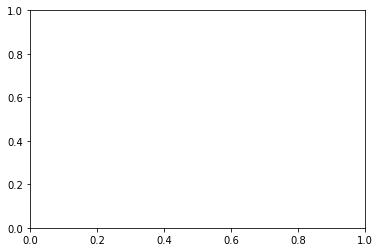

In [5]:
fig, ax = plt.subplots()
ax.plot( kbin,Cpb)
ax.plot( kbin,mock_covbp[:,idx_kmin:idx_kmax].ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(r'~$C_{p,b}$')
#ax.set_ylim(-50000,50000)


fig, ax = plt.subplots()
ax.plot( kbin,mock_covp[idx_kmin:idx_kmax,idx_kmin:idx_kmax ].diagonal())
ax.plot( kbin,covp_model[idx_kmin:idx_kmax,idx_kmin:idx_kmax ].diagonal())
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel('$C_{p}$')
#ax.set_ylim(-50000,50000)


fig, ax = plt.subplots()
ax.plot( kbin, final_p)
ax.plot( kbin, final_mock_p.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(r'$C_{p,b} [C_{p}]^{-1}$')
#ax.set_ylim(-50000,50000)